<a href="https://colab.research.google.com/github/Hydra-Slayer/Image-encryption-using-Chaotic-Map/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

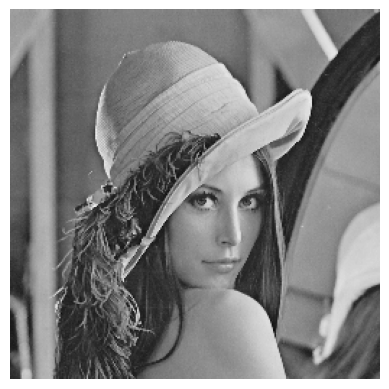

flattened image
Scrambling complete. File saved at scrambled_image.png


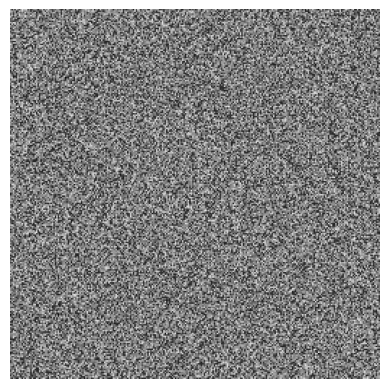

xor operation complete


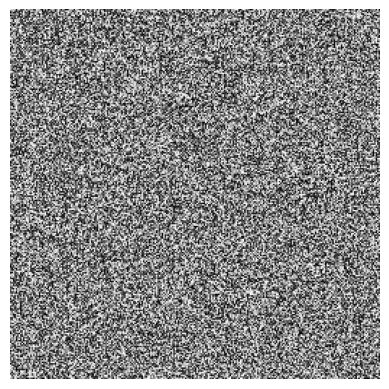

xor operation complete


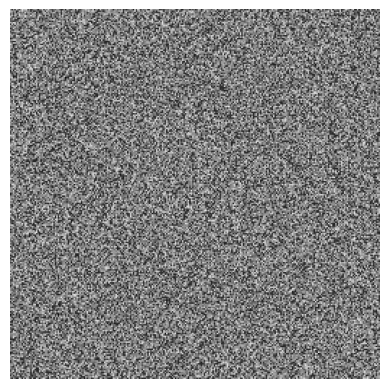

flattened image
Descrambling complete. File saved at descrambled_image.png


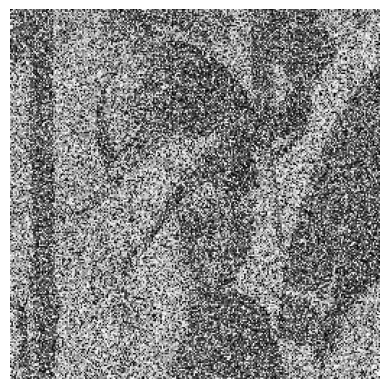

flattened image
Descrambling complete. File saved at decrypted_unscrambled_image.png


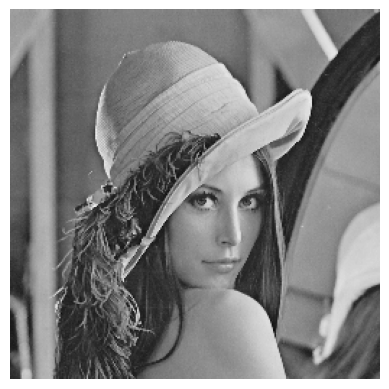

In [45]:
# import dependencies
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def map(x0, R):
    """ Define a function called 'map' which returns the value of x1 for a given x0 and R. """
    return x0 * R * (1 - x0)

def orbit(x0, R, maxiter):
    """ Define a function that returns an orbit, that is, the values of x1, x2, ..., xn starting from a given x0 and R. """
    # Initialize a list and set the first element to x0
    x = [x0]
    # Generate the full map values
    for n in range(maxiter):
        x.append(map(x[-1], R))
    return x

# Add index and sort by the second value in each tuple
def add_index_to_map(map_matrix):
  '''Adds a index to the map matrix and returns the sorted map index values only'''
  enumerated_x = list(enumerate(x))
  # print(enumerated_x)
  enumerated_x.sort(key=lambda x: x[1])
  indexes = [index for index, _ in enumerated_x]
  return indexes

def show_image(image_path):
  # Load the image and convert to grayscale
    image = Image.open(image_path).convert('L')
    # Convert the image to a numpy array (grayscale)
    image_matrix = np.array(image)
    plt.imshow(image_matrix, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.show()

def flatten_image(image_path):
    """
    Flatten a grayscale image into a 1D array.

    Parameters:
    - image_path: Path to the input grayscale image.

    Returns:
    - flattened_image: Flattened 1D array of pixel values.
    - original_shape: Tuple containing the original shape of the image (for reshaping after operations).
    """
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert('L')

    # Convert the image to a numpy array (grayscale)
    image_matrix = np.array(image)

    # Get the original shape of the image
    original_shape = image_matrix.shape

    # Flatten the 2D image matrix into a 1D array
    flattened_image = image_matrix.flatten()
    print("flattened image")
    return flattened_image, original_shape


#encrypt fucntion
def scramble(image_path, chaotic_map_indices, output_path):
    """
    Scrambles a grayscale image based on chaotic map indices.

    Parameters:
    - image_path: Path to the input grayscale image.
    - chaotic_map_indices: List of indices generated by the chaotic map for scrambling.
    - output_path: Path to save the scrambled image.
    """

    flattened_image, orignal_shape = flatten_image(image_path)

    # Reorder the flattened image according to the chaotic map indices
    scrambled_image = np.array([flattened_image[i] for i in chaotic_map_indices])

    # Reshape the scrambled list back into the original 2D image shape
    scrambled_matrix = scrambled_image.reshape(orignal_shape)

    # Convert the scrambled matrix back to an image
    scrambled_image = Image.fromarray(np.uint8(scrambled_matrix))

    # Save the scrambled image
    scrambled_image.save(output_path)

    print(f"Scrambling complete. File saved at {output_path}")
    show_image('scrambled_image.png')


## generates a key stream from the chaotic map
def generate_key_stream_from_chaos(image_shape, x0, R, maxiter):
    """
    Generates a key stream based on chaotic map values.

    Parameters:
    - image_shape: Tuple representing the shape of the image (height, width).
    - x0: Initial value for chaotic map.
    - R: Control parameter for chaotic map.
    - maxiter: Number of iterations for the chaotic map.

    Returns:
    - key_stream: 2D numpy array of the same shape as the image, containing the key stream.
    """
    # Generate chaotic map values
    x = orbit(x0, R, maxiter)

    # Scale chaotic values to the 0-255 range
    x_scaled = np.array(x[:np.prod(image_shape)]) * 255

    # Ensure values are within the 0-255 range
    x_scaled = np.clip(x_scaled, 0, 255)

    # Reshape to match image shape
    key_stream = x_scaled.reshape(image_shape).astype(np.uint8)

    return key_stream


# def generate_key_stream_from_chaos(image_shape, x0, R, maxiter):
#     """
#     Generates a key stream based on chaotic map values scaled by a large number.

#     Parameters:
#     - image_shape: Tuple representing the shape of the image (height, width).
#     - x0: Initial value for chaotic map.
#     - R: Control parameter for chaotic map.
#     - maxiter: Number of iterations for the chaotic map.
#     - large_number: Large number to scale chaotic map values.

#     Returns:
#     - key_stream: 2D numpy array of the same shape as the image, containing the key stream.
#     """
#     # Generate chaotic map values
#     x = orbit(x0, R, maxiter)

#     # Scale chaotic values by a large number
#     x_scaled = np.array(x[:np.prod(image_shape)]) * (10**26)

#     # Reduce to 0-255 range using modulo operation
#     key_stream = np.mod(x_scaled, 256)

#     # Reshape to match image shape and ensure values are uint8
#     key_stream = key_stream.reshape(image_shape).astype(np.uint8)

#     return key_stream

## xor image values with map values
def xor_with_key(img_path, key_stream, output_img_path):
    """
    Applies XOR operation between the scrambled image matrix and a key stream.

    Parameters:
    - image_matrix: 2D numpy array representing the grayscale scrambled image.
    - key_stream: 1D or 2D numpy array representing the key stream (should match image size).

    Returns:
    - xor_result: 2D numpy array of the XORed image.
    """

    scrambled_image_path = img_path
    scrambled_image = Image.open(scrambled_image_path).convert('L')
    image_matrix = np.array(scrambled_image)
    # Ensure the key_stream is the same shape as the image_matrix
    assert image_matrix.shape == key_stream.shape, "Key stream and image size must match."

    # Apply XOR between each pixel value and the corresponding key stream value
    xor_result = np.bitwise_xor(image_matrix, key_stream)
    # Convert the XORed result back to an image and save or show it
    xor_image = Image.fromarray(xor_result)
    xor_image.save(f"{output_img_path}")
    print("xor operation complete")
    show_image(f"{output_img_path}")



### Set initial parameters
u = 3.8
x0 = 0.5
iterations = 65535

# Generate map values
x = orbit(x0, u, iterations)
indexes = add_index_to_map(x)
img_shape = (256,256)
# print(indexes)

show_image('lena_grayscale.png')

scramble('lena_grayscale.png', indexes, 'scrambled_image.png')








def unscramble(encrypted_image_path, chaotic_map_indices, output_path):
    """
    Decrypts a scrambled grayscale image based on the original chaotic map indices.

    Parameters:
    - encrypted_image_path: Path to the scrambled (encrypted) grayscale image.
    - chaotic_map_indices: List of indices generated by the chaotic map used for scrambling.
    - output_path: Path to save the unscrambled (decrypted) image.
    """

    # Flatten the 2D scrambled matrix into a 1D array
    scrambled_flattened, shape = flatten_image(encrypted_image_path)

    # Initialize an array for the decrypted image (same size as the scrambled_flattened array)
    decrypted_image = np.zeros_like(scrambled_flattened)

    # Reverse the scrambling process by placing the scrambled pixels back to their original positions
    for i, index in enumerate(chaotic_map_indices):
        decrypted_image[index] = scrambled_flattened[i]

    # Reshape the decrypted 1D array back into the original 2D image shape
    decrypted_matrix = decrypted_image.reshape(shape)

    # Convert the decrypted matrix back to an image
    decrypted_image = Image.fromarray(np.uint8(decrypted_matrix))

    # Save the decrypted image
    decrypted_image.save(output_path)

    print(f"Descrambling complete. File saved at {output_path}")
    show_image(f'{output_path}')


keys = generate_key_stream_from_chaos(img_shape, x0, u, iterations)
xor_with_key('scrambled_image.png', keys,'xor_first_time.png')
xor_with_key('xor_first_time.png', keys,'xor_second_time.png')
unscramble('xor_first_time.png', indexes, 'descrambled_image.png')
unscramble('xor_second_time.png', indexes, 'decrypted_unscrambled_image.png')


### A Block for Testing new code
